In [19]:
# 1. Các thư viện cần thiết
!pip3 install -U git+https://github.com/PYFTS/pyFTS
import pandas as pd
import numpy as np
from pyFTS.models import hofts
from pyFTS.partitioners import Grid
from pyFTS.models import chen
from pyFTS.common import FLR
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# Fix the import in the pyFTS library if necessary
# In the file '/usr/local/lib/python3.10/dist-packages/pyFTS/common/transformations/trend.py', change:
# from pandas import datetime
# to:
# from pandas import Timestamp

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-v1jobu5s
  Running command git clone --filter=blob:none --quiet https://github.com/PYFTS/pyFTS /tmp/pip-req-build-v1jobu5s
  Resolved https://github.com/PYFTS/pyFTS to commit 4e0ee7cdd9fc9a8ac9170c0c3496536ef0378cb7
  Preparing metadata (setup.py) ... done


# **Chia train test theo tỉ lệ 8:2**

In [47]:
# 2. Đọc file csv và lấy  giá Close
df = pd.read_csv('Bnb.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df1 = df['Close'].values

In [48]:
# 3. Chia train, test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

/usr/local/lib/python3.10/dist-packages/pyFTS/partitioners/partitioner.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


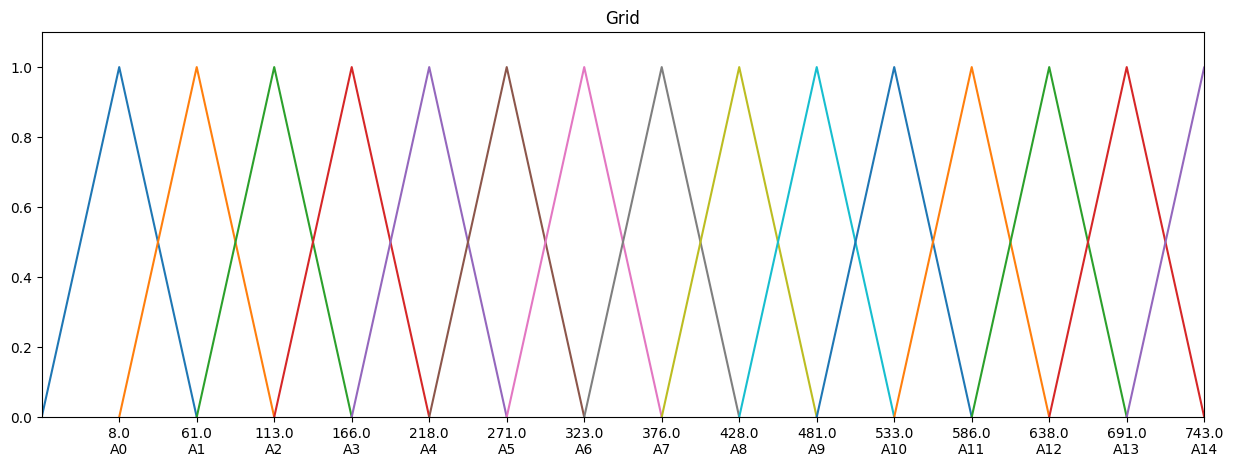

In [49]:
# 4. Xây dựng phân vùng mờ (Grid Partitioner)
partitioner = Grid.GridPartitioner(data=train_data, npart=15)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
partitioner.plot(ax)

In [50]:
# 5. Fuzzyfy dữ liệu huấn luyện (Chuyển đổi dữ liệu huấn luyện thành các giá trị mờ)
fuzzyfied = partitioner.fuzzyfy(train_data)

In [51]:
# 6. Tạo các mối quan hệ logic giữa các  mờ (FLR)
patterns = FLR.generate_non_recurrent_flrs(fuzzyfied)
print([str(k) for k in patterns])

['A0 -> A0', 'A0 -> A1', 'A1 -> A0', 'A1 -> A1', 'A0 -> A2', 'A1 -> A2', 'A2 -> A1', 'A2 -> A2', 'A1 -> A3', 'A2 -> A3', 'A3 -> A2', 'A3 -> A3', 'A2 -> A4', 'A3 -> A4', 'A3 -> A6', 'A3 -> A7', 'A4 -> A6', 'A4 -> A7', 'A6 -> A4', 'A6 -> A5', 'A7 -> A4', 'A7 -> A5', 'A4 -> A5', 'A5 -> A5', 'A5 -> A6', 'A5 -> A4', 'A4 -> A4', 'A4 -> A3', 'A5 -> A3', 'A3 -> A5', 'A6 -> A6', 'A5 -> A7', 'A6 -> A7', 'A7 -> A6', 'A7 -> A7', 'A6 -> A8', 'A7 -> A8', 'A8 -> A6', 'A8 -> A7', 'A7 -> A9', 'A8 -> A8', 'A8 -> A9', 'A9 -> A8', 'A9 -> A9', 'A8 -> A10', 'A9 -> A10', 'A9 -> A11', 'A9 -> A12', 'A10 -> A11', 'A10 -> A12', 'A11 -> A10', 'A11 -> A11', 'A12 -> A10', 'A12 -> A11', 'A10 -> A10', 'A10 -> A9', 'A11 -> A9', 'A11 -> A12', 'A12 -> A12', 'A11 -> A13', 'A12 -> A13', 'A13 -> A11', 'A13 -> A12', 'A13 -> A13', 'A9 -> A6', 'A9 -> A7', 'A10 -> A6', 'A10 -> A7', 'A10 -> A8']


In [52]:
# 7. Xây dựng mô hình FTS
model = hofts.HighOrderFTS(order=2, partitioner=partitioner)
model.fit(train_data)
print(model)

High Order FTS:
A0,A0 -> A0,A1,A2
A0,A1 -> A0,A1,A2
A1,A0 -> A0,A1,A2
A1,A1 -> A0,A1,A2,A3
A0,A2 -> A1,A2
A1,A2 -> A1,A2,A3
A2,A1 -> A1,A2,A3
A2,A2 -> A1,A2,A3,A4
A1,A3 -> A2,A3
A3,A2 -> A2,A3,A4
A4,A3 -> A3,A4,A5
A5,A3 -> A3,A4,A5
A3,A5 -> A3,A4,A5
A2,A3 -> A2,A3,A4,A6,A7
A3,A3 -> A2,A3,A4,A5,A6,A7
A3,A6 -> A4,A5
A3,A7 -> A4,A5
A4,A5 -> A3,A4,A5,A6
A4,A4 -> A3,A4,A5,A6
A3,A4 -> A3,A4,A5,A6,A7
A5,A5 -> A3,A4,A5,A6,A7
A5,A4 -> A3,A4,A5,A6,A7
A4,A6 -> A4,A5,A6,A7
A4,A7 -> A4,A5,A6,A7
A6,A4 -> A4,A5,A6,A7
A6,A5 -> A4,A5,A6,A7
A7,A4 -> A5,A6
A7,A5 -> A4,A5,A6,A7
A5,A6 -> A4,A5,A6,A7
A5,A7 -> A5,A6,A7
A6,A6 -> A4,A5,A6,A7,A8
A7,A6 -> A4,A5,A6,A7,A8
A2,A4 -> A6,A7
A6,A7 -> A4,A5,A6,A7,A8,A9
A7,A7 -> A4,A5,A6,A7,A8,A9
A8,A6 -> A5,A6,A7,A8
A8,A7 -> A5,A6,A7,A8,A9
A6,A8 -> A6,A7,A8,A9
A9,A6 -> A7,A8
A9,A7 -> A6,A7,A8,A9
A10,A6 -> A7,A8
A10,A7 -> A7,A8
A7,A8 -> A10,A6,A7,A8,A9
A8,A8 -> A10,A6,A7,A8,A9
A9,A8 -> A10,A6,A7,A8,A9
A7,A9 -> A10,A7,A8,A9
A10,A8 -> A10,A7,A8,A9
A9,A9 -> A10,A11,A12,A6,A

In [53]:
# 8. Dự đoán dữ liệu test
train_predict = model.predict(train_data)
y_pred_test = model.predict(test_data)

# Điều chỉnh độ dài để dự đoán
min_length = min(len(y_pred_test), len(test_data))
y_pred_test = y_pred_test[:min_length]
test_data = test_data[:min_length]

In [54]:
# 10. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, test_data)
test_mape = mean_absolute_percentage_error(y_pred_test, test_data)
test_rmse = np.sqrt(mean_squared_error(y_pred_test, test_data))
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Testing MAE: 18.140921781282128
Testing RMSE: 21.185729320606672
Testing MAPE: 0.062016654625206516


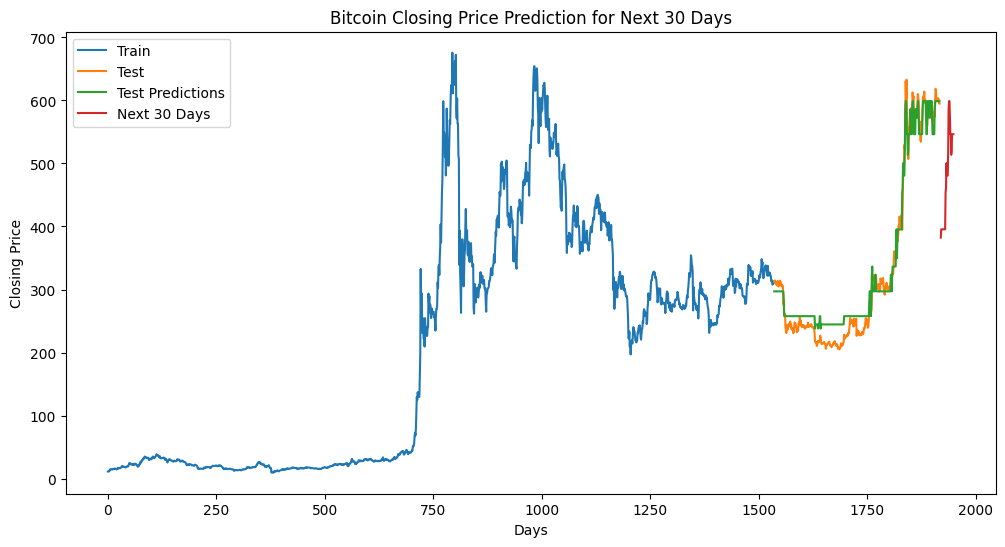

Predicted closing prices for the next 30 days:
[382.41072703 395.53224569 395.53224569 395.53224569 395.53224569
 395.53224569 395.53224569 395.53224569 395.53224569 395.53224569
 395.53224569 454.57907966 461.139839   500.50439498 480.82211699
 480.82211699 480.82211699 520.18667297 585.79426627 598.91578493
 598.91578493 572.67274761 546.42971029 546.42971029 513.62591364
 520.18667297 546.42971029 546.42971029 546.42971029 546.42971029]


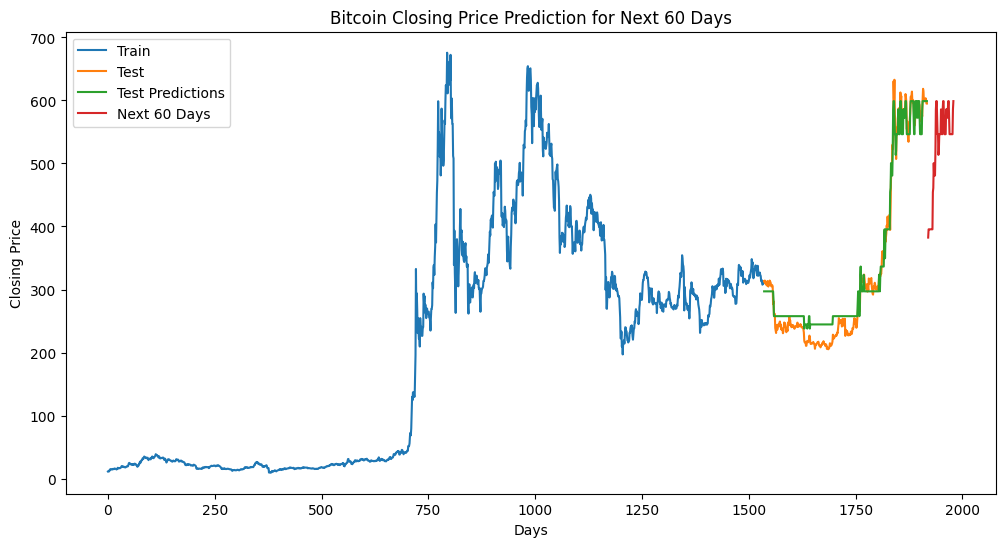

Predicted closing prices for the next 60 days:
[382.41072703 395.53224569 395.53224569 395.53224569 395.53224569
 395.53224569 395.53224569 395.53224569 395.53224569 395.53224569
 395.53224569 454.57907966 461.139839   500.50439498 480.82211699
 480.82211699 480.82211699 520.18667297 585.79426627 598.91578493
 598.91578493 572.67274761 546.42971029 546.42971029 513.62591364
 520.18667297 546.42971029 546.42971029 546.42971029 546.42971029
 585.79426627 572.67274761 546.42971029 546.42971029 585.79426627
 598.91578493 598.91578493 572.67274761 546.42971029 546.42971029
 546.42971029 546.42971029 585.79426627 572.67274761 585.79426627
 572.67274761 585.79426627 598.91578493 598.91578493 572.67274761
 546.42971029 546.42971029 546.42971029 546.42971029 546.42971029
 546.42971029 546.42971029 546.42971029 585.79426627 598.91578493]


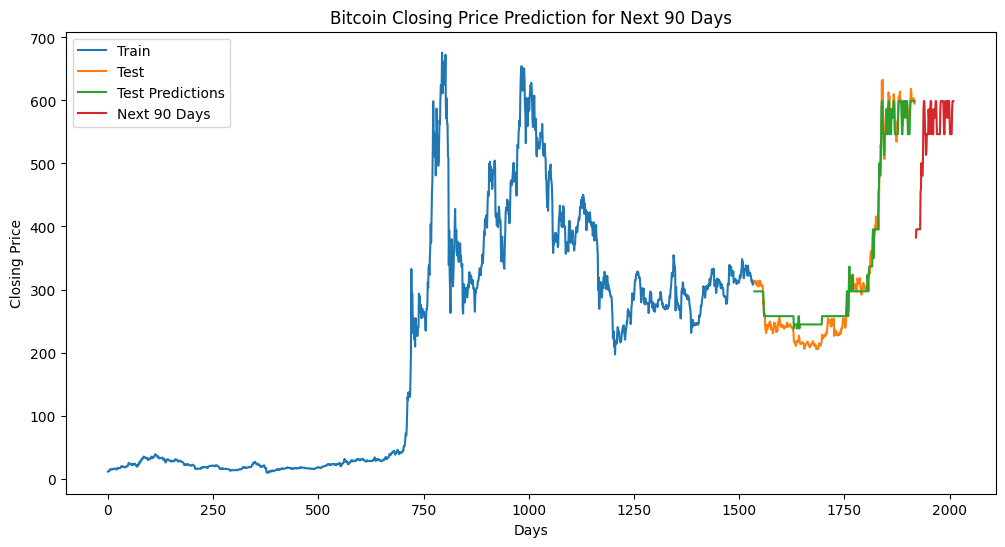

Predicted closing prices for the next 90 days:
[382.41072703 395.53224569 395.53224569 395.53224569 395.53224569
 395.53224569 395.53224569 395.53224569 395.53224569 395.53224569
 395.53224569 454.57907966 461.139839   500.50439498 480.82211699
 480.82211699 480.82211699 520.18667297 585.79426627 598.91578493
 598.91578493 572.67274761 546.42971029 546.42971029 513.62591364
 520.18667297 546.42971029 546.42971029 546.42971029 546.42971029
 585.79426627 572.67274761 546.42971029 546.42971029 585.79426627
 598.91578493 598.91578493 572.67274761 546.42971029 546.42971029
 546.42971029 546.42971029 585.79426627 572.67274761 585.79426627
 572.67274761 585.79426627 598.91578493 598.91578493 572.67274761
 546.42971029 546.42971029 546.42971029 546.42971029 546.42971029
 546.42971029 546.42971029 546.42971029 585.79426627 598.91578493
 598.91578493 598.91578493 598.91578493 598.91578493 598.91578493
 598.91578493 572.67274761 546.42971029 546.42971029 585.79426627
 598.91578493 598.91578493 59

In [55]:
# 10. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[-time_step:])
    lst_output = []

    for _ in range(days):
        x_input = np.array(temp_input[-time_step:])  # Lấy 100 dữ liệu lịch sử
        yhat = model.predict(x_input)[0]  # Dự đoán dữ liệu tiếp theo
        temp_input.append(yhat)
        lst_output.append(yhat)

    return np.array(lst_output)

last_100_days = df1[-100:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, 100, days)

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), y_pred_test, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())


# **Chia train test theo tỉ lệ 7:3**

In [56]:
# 2. Đọc file csv và lấy  giá Close
df = pd.read_csv('Bnb.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df1 = df['Close'].values

In [57]:
# 3. Chia train, test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

/usr/local/lib/python3.10/dist-packages/pyFTS/partitioners/partitioner.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


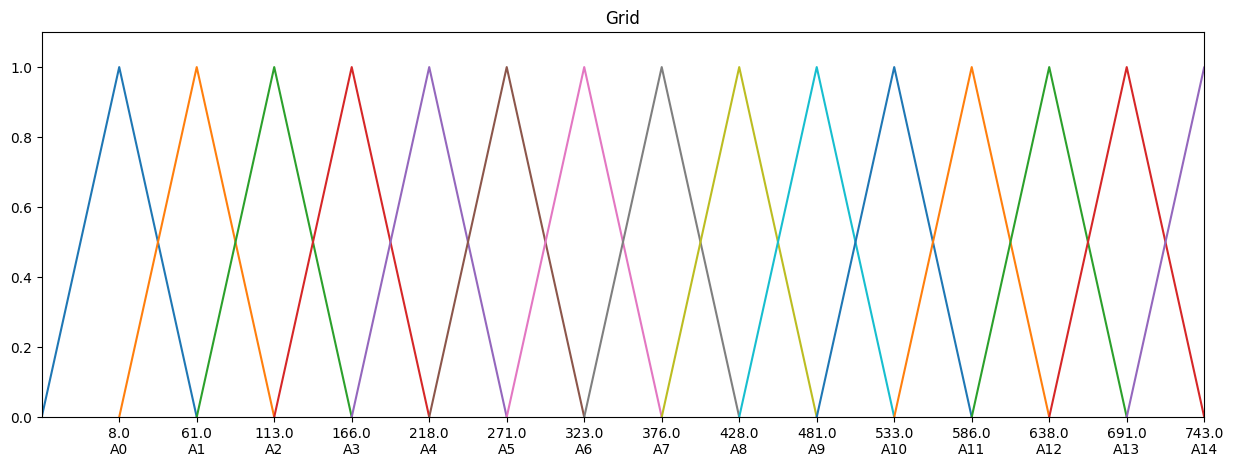

In [58]:
# 4. Xây dựng phân vùng mờ (Grid Partitioner)
partitioner = Grid.GridPartitioner(data=train_data, npart=15)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
partitioner.plot(ax)

In [59]:
# 5. Fuzzyfy dữ liệu huấn luyện (Chuyển đổi dữ liệu huấn luyện thành các giá trị mờ)
fuzzyfied = partitioner.fuzzyfy(train_data)

In [60]:
# 6. Tạo các mối quan hệ logic giữa các  mờ (FLR)
patterns = FLR.generate_non_recurrent_flrs(fuzzyfied)
print([str(k) for k in patterns])

['A0 -> A0', 'A0 -> A1', 'A1 -> A0', 'A1 -> A1', 'A0 -> A2', 'A1 -> A2', 'A2 -> A1', 'A2 -> A2', 'A1 -> A3', 'A2 -> A3', 'A3 -> A2', 'A3 -> A3', 'A2 -> A4', 'A3 -> A4', 'A3 -> A6', 'A3 -> A7', 'A4 -> A6', 'A4 -> A7', 'A6 -> A4', 'A6 -> A5', 'A7 -> A4', 'A7 -> A5', 'A4 -> A5', 'A5 -> A5', 'A5 -> A6', 'A5 -> A4', 'A4 -> A4', 'A4 -> A3', 'A5 -> A3', 'A3 -> A5', 'A6 -> A6', 'A5 -> A7', 'A6 -> A7', 'A7 -> A6', 'A7 -> A7', 'A6 -> A8', 'A7 -> A8', 'A8 -> A6', 'A8 -> A7', 'A7 -> A9', 'A8 -> A8', 'A8 -> A9', 'A9 -> A8', 'A9 -> A9', 'A8 -> A10', 'A9 -> A10', 'A9 -> A11', 'A9 -> A12', 'A10 -> A11', 'A10 -> A12', 'A11 -> A10', 'A11 -> A11', 'A12 -> A10', 'A12 -> A11', 'A10 -> A10', 'A10 -> A9', 'A11 -> A9', 'A11 -> A12', 'A12 -> A12', 'A11 -> A13', 'A12 -> A13', 'A13 -> A11', 'A13 -> A12', 'A13 -> A13', 'A9 -> A6', 'A9 -> A7', 'A10 -> A6', 'A10 -> A7', 'A10 -> A8']


In [61]:
# 7. Xây dựng mô hình FTS
model = hofts.HighOrderFTS(order=2, partitioner=partitioner)
model.fit(train_data)
print(model)

High Order FTS:
A0,A0 -> A0,A1,A2
A0,A1 -> A0,A1,A2
A1,A0 -> A0,A1,A2
A1,A1 -> A0,A1,A2,A3
A0,A2 -> A1,A2
A1,A2 -> A1,A2,A3
A2,A1 -> A1,A2,A3
A2,A2 -> A1,A2,A3,A4
A1,A3 -> A2,A3
A3,A2 -> A2,A3,A4
A4,A3 -> A3,A4,A5
A5,A3 -> A3,A4,A5
A3,A5 -> A3,A4,A5
A2,A3 -> A2,A3,A4,A6,A7
A3,A3 -> A2,A3,A4,A5,A6,A7
A3,A6 -> A4,A5
A3,A7 -> A4,A5
A4,A5 -> A3,A4,A5,A6
A4,A4 -> A3,A4,A5,A6
A3,A4 -> A3,A4,A5,A6,A7
A5,A5 -> A3,A4,A5,A6,A7
A5,A4 -> A3,A4,A5,A6,A7
A4,A6 -> A4,A5,A6,A7
A4,A7 -> A4,A5,A6,A7
A6,A4 -> A4,A5,A6,A7
A6,A5 -> A4,A5,A6,A7
A7,A4 -> A5,A6
A7,A5 -> A4,A5,A6,A7
A5,A6 -> A4,A5,A6,A7
A5,A7 -> A5,A6,A7
A6,A6 -> A4,A5,A6,A7,A8
A7,A6 -> A4,A5,A6,A7,A8
A2,A4 -> A6,A7
A8,A6 -> A5,A6,A7,A8
A6,A7 -> A5,A6,A7,A8,A9
A7,A7 -> A5,A6,A7,A8,A9
A8,A7 -> A5,A6,A7,A8,A9
A6,A8 -> A6,A7,A8,A9
A9,A6 -> A7,A8
A9,A7 -> A6,A7,A8,A9
A10,A6 -> A7,A8
A10,A7 -> A7,A8
A7,A8 -> A10,A6,A7,A8,A9
A8,A8 -> A10,A6,A7,A8,A9
A9,A8 -> A10,A6,A7,A8,A9
A7,A9 -> A10,A7,A8,A9
A10,A8 -> A10,A7,A8,A9
A9,A9 -> A10,A11,A12,A6,A7,A8,A

In [62]:
# 8. Dự đoán dữ liệu test
train_predict = model.predict(train_data)
y_pred_test = model.predict(test_data)

# Điều chỉnh độ dài để dự đoán
min_length = min(len(y_pred_test), len(test_data))
y_pred_test = y_pred_test[:min_length]
test_data = test_data[:min_length]

In [63]:
# 9. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, test_data)
test_mape = mean_absolute_percentage_error(y_pred_test, test_data)
test_rmse = np.sqrt(mean_squared_error(y_pred_test, test_data))
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Testing MAE: 16.3667137059115
Testing RMSE: 19.248519960362856
Testing MAPE: 0.055459445068101


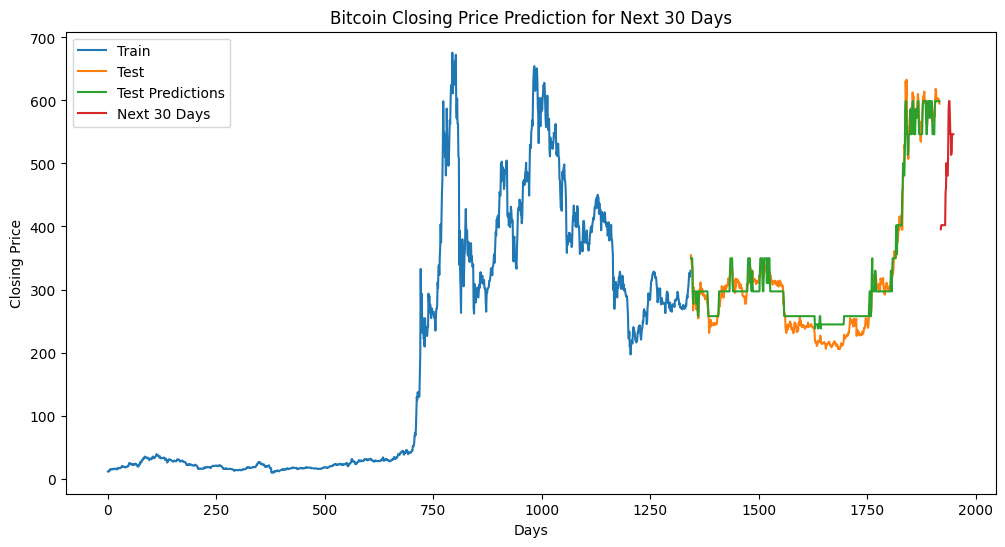

Predicted closing prices for the next 30 days:
[395.53224569 402.09300502 402.09300502 402.09300502 402.09300502
 402.09300502 402.09300502 402.09300502 402.09300502 402.09300502
 402.09300502 454.57907966 461.139839   500.50439498 480.82211699
 480.82211699 480.82211699 520.18667297 585.79426627 598.91578493
 598.91578493 572.67274761 546.42971029 546.42971029 513.62591364
 520.18667297 546.42971029 546.42971029 546.42971029 546.42971029]


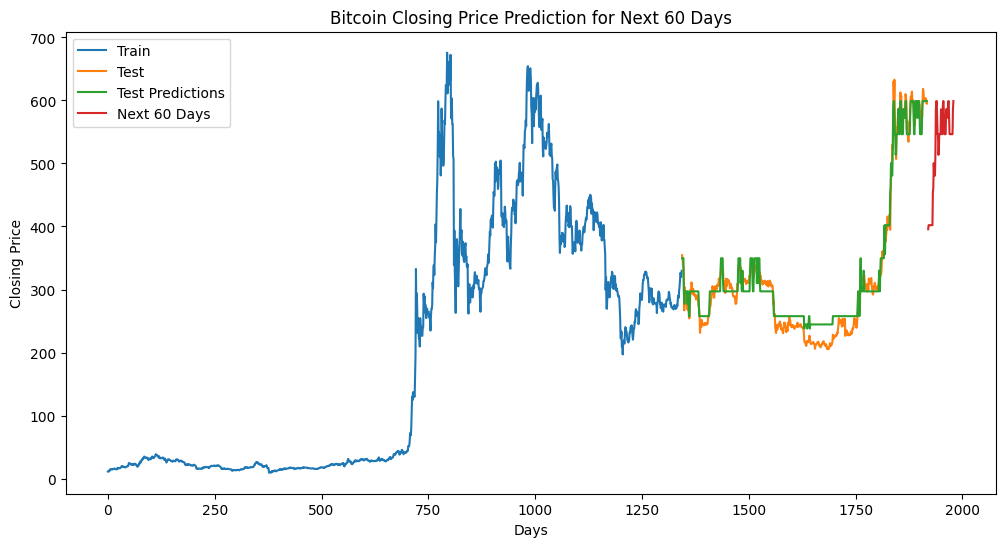

Predicted closing prices for the next 60 days:
[395.53224569 402.09300502 402.09300502 402.09300502 402.09300502
 402.09300502 402.09300502 402.09300502 402.09300502 402.09300502
 402.09300502 454.57907966 461.139839   500.50439498 480.82211699
 480.82211699 480.82211699 520.18667297 585.79426627 598.91578493
 598.91578493 572.67274761 546.42971029 546.42971029 513.62591364
 520.18667297 546.42971029 546.42971029 546.42971029 546.42971029
 585.79426627 572.67274761 546.42971029 546.42971029 585.79426627
 598.91578493 598.91578493 572.67274761 546.42971029 546.42971029
 546.42971029 546.42971029 585.79426627 572.67274761 585.79426627
 572.67274761 585.79426627 598.91578493 598.91578493 572.67274761
 546.42971029 546.42971029 546.42971029 546.42971029 546.42971029
 546.42971029 546.42971029 546.42971029 585.79426627 598.91578493]


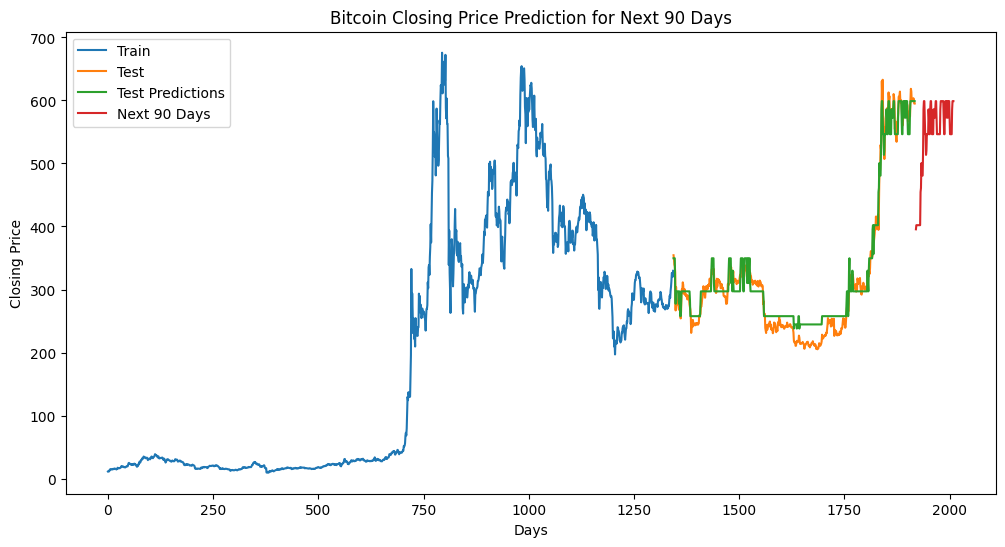

Predicted closing prices for the next 90 days:
[395.53224569 402.09300502 402.09300502 402.09300502 402.09300502
 402.09300502 402.09300502 402.09300502 402.09300502 402.09300502
 402.09300502 454.57907966 461.139839   500.50439498 480.82211699
 480.82211699 480.82211699 520.18667297 585.79426627 598.91578493
 598.91578493 572.67274761 546.42971029 546.42971029 513.62591364
 520.18667297 546.42971029 546.42971029 546.42971029 546.42971029
 585.79426627 572.67274761 546.42971029 546.42971029 585.79426627
 598.91578493 598.91578493 572.67274761 546.42971029 546.42971029
 546.42971029 546.42971029 585.79426627 572.67274761 585.79426627
 572.67274761 585.79426627 598.91578493 598.91578493 572.67274761
 546.42971029 546.42971029 546.42971029 546.42971029 546.42971029
 546.42971029 546.42971029 546.42971029 585.79426627 598.91578493
 598.91578493 598.91578493 598.91578493 598.91578493 598.91578493
 598.91578493 572.67274761 546.42971029 546.42971029 585.79426627
 598.91578493 598.91578493 59

In [64]:
# 10. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[-time_step:])
    lst_output = []

    for _ in range(days):
        x_input = np.array(temp_input[-time_step:])  # Lấy 100 dữ liệu lịch sử
        yhat = model.predict(x_input)[0]  # Dự đoán dữ liệu tiếp theo
        temp_input.append(yhat)
        lst_output.append(yhat)

    return np.array(lst_output)

last_100_days = df1[-100:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, 100, days)

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), y_pred_test, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **Chia train test theo tỉ lệ 6:4**

In [65]:
# 2. Đọc file csv và lấy  giá Close
df = pd.read_csv('Bnb.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df1 = df['Close'].values

In [66]:
# 3. Chia train, test
train_size = int(0.6 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

/usr/local/lib/python3.10/dist-packages/pyFTS/partitioners/partitioner.py:278: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(ticks)


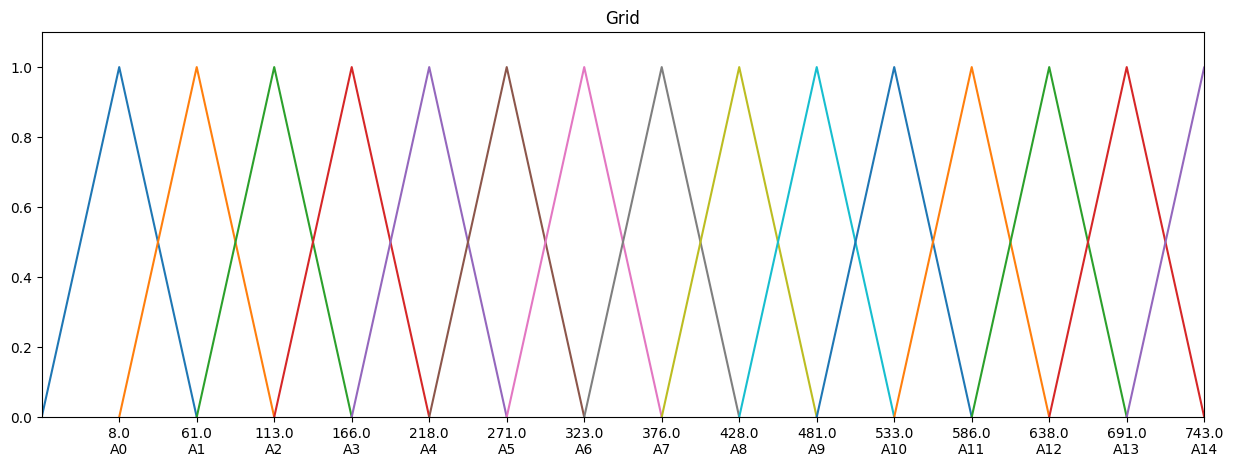

In [67]:
# 4. Xây dựng phân vùng mờ (Grid Partitioner)
partitioner = Grid.GridPartitioner(data=train_data, npart=15)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
partitioner.plot(ax)

In [68]:
# 5. Fuzzyfy dữ liệu huấn luyện (Chuyển đổi dữ liệu huấn luyện thành các giá trị mờ)
fuzzyfied = partitioner.fuzzyfy(train_data)

In [69]:
# 6. Tạo các mối quan hệ logic giữa các  mờ (FLR)
patterns = FLR.generate_non_recurrent_flrs(fuzzyfied)
print([str(k) for k in patterns])

['A0 -> A0', 'A0 -> A1', 'A1 -> A0', 'A1 -> A1', 'A0 -> A2', 'A1 -> A2', 'A2 -> A1', 'A2 -> A2', 'A1 -> A3', 'A2 -> A3', 'A3 -> A2', 'A3 -> A3', 'A2 -> A4', 'A3 -> A4', 'A3 -> A6', 'A3 -> A7', 'A4 -> A6', 'A4 -> A7', 'A6 -> A4', 'A6 -> A5', 'A7 -> A4', 'A7 -> A5', 'A4 -> A5', 'A5 -> A5', 'A5 -> A6', 'A5 -> A4', 'A4 -> A4', 'A4 -> A3', 'A5 -> A3', 'A3 -> A5', 'A6 -> A6', 'A5 -> A7', 'A6 -> A7', 'A7 -> A6', 'A7 -> A7', 'A6 -> A8', 'A7 -> A8', 'A8 -> A6', 'A8 -> A7', 'A7 -> A9', 'A8 -> A8', 'A8 -> A9', 'A9 -> A8', 'A9 -> A9', 'A8 -> A10', 'A9 -> A10', 'A9 -> A11', 'A9 -> A12', 'A10 -> A11', 'A10 -> A12', 'A11 -> A10', 'A11 -> A11', 'A12 -> A10', 'A12 -> A11', 'A10 -> A10', 'A10 -> A9', 'A11 -> A9', 'A11 -> A12', 'A12 -> A12', 'A11 -> A13', 'A12 -> A13', 'A13 -> A11', 'A13 -> A12', 'A13 -> A13', 'A9 -> A6', 'A9 -> A7', 'A10 -> A6', 'A10 -> A7', 'A10 -> A8']


In [70]:
# 7. Xây dựng mô hình FTS
model = hofts.HighOrderFTS(order=2, partitioner=partitioner)
model.fit(train_data)
print(model)

High Order FTS:
A0,A0 -> A0,A1,A2
A0,A1 -> A0,A1,A2
A1,A0 -> A0,A1,A2
A1,A1 -> A0,A1,A2,A3
A0,A2 -> A1,A2
A1,A2 -> A1,A2,A3
A2,A1 -> A1,A2,A3
A2,A2 -> A1,A2,A3,A4
A1,A3 -> A2,A3
A3,A2 -> A2,A3,A4
A2,A3 -> A2,A3,A4,A6,A7
A3,A3 -> A2,A3,A4,A6,A7
A3,A6 -> A4,A5
A3,A7 -> A4,A5
A4,A5 -> A3,A4,A5,A6
A4,A4 -> A3,A4,A5,A6
A4,A3 -> A4,A5
A5,A3 -> A4,A5
A3,A5 -> A4,A5
A5,A5 -> A3,A4,A5,A6,A7
A5,A4 -> A3,A4,A5,A6,A7
A3,A4 -> A4,A5,A6,A7
A4,A6 -> A4,A5,A6,A7
A4,A7 -> A4,A5,A6,A7
A6,A4 -> A4,A5,A6,A7
A6,A5 -> A4,A5,A6,A7
A7,A4 -> A5,A6
A7,A5 -> A4,A5,A6,A7
A5,A6 -> A4,A5,A6,A7
A5,A7 -> A5,A6,A7
A6,A6 -> A4,A5,A6,A7,A8
A7,A6 -> A4,A5,A6,A7,A8
A2,A4 -> A6,A7
A8,A6 -> A5,A6,A7,A8
A6,A7 -> A5,A6,A7,A8,A9
A7,A7 -> A5,A6,A7,A8,A9
A8,A7 -> A5,A6,A7,A8,A9
A6,A8 -> A6,A7,A8,A9
A9,A6 -> A7,A8
A9,A7 -> A6,A7,A8,A9
A10,A6 -> A7,A8
A10,A7 -> A7,A8
A7,A8 -> A10,A6,A7,A8,A9
A8,A8 -> A10,A6,A7,A8,A9
A9,A8 -> A10,A6,A7,A8,A9
A7,A9 -> A10,A7,A8,A9
A10,A8 -> A10,A7,A8,A9
A9,A9 -> A10,A11,A12,A6,A7,A8,A9
A9,A10 -> A10

In [71]:
# 8. Dự đoán dữ liệu test
train_predict = model.predict(train_data)
y_pred_test = model.predict(test_data)

# Điều chỉnh độ dài để dự đoán
min_length = min(len(y_pred_test), len(test_data))
y_pred_test = y_pred_test[:min_length]
test_data = test_data[:min_length]

In [72]:
# 9. Đánh giá độ chính xác thuật toán
test_mae = mean_absolute_error(y_pred_test, test_data)
test_mape = mean_absolute_percentage_error(y_pred_test, test_data)
test_rmse = np.sqrt(mean_squared_error(y_pred_test, test_data))
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Testing MAE: 17.29908695779278
Testing RMSE: 21.120018324041254
Testing MAPE: 0.05904290289765352


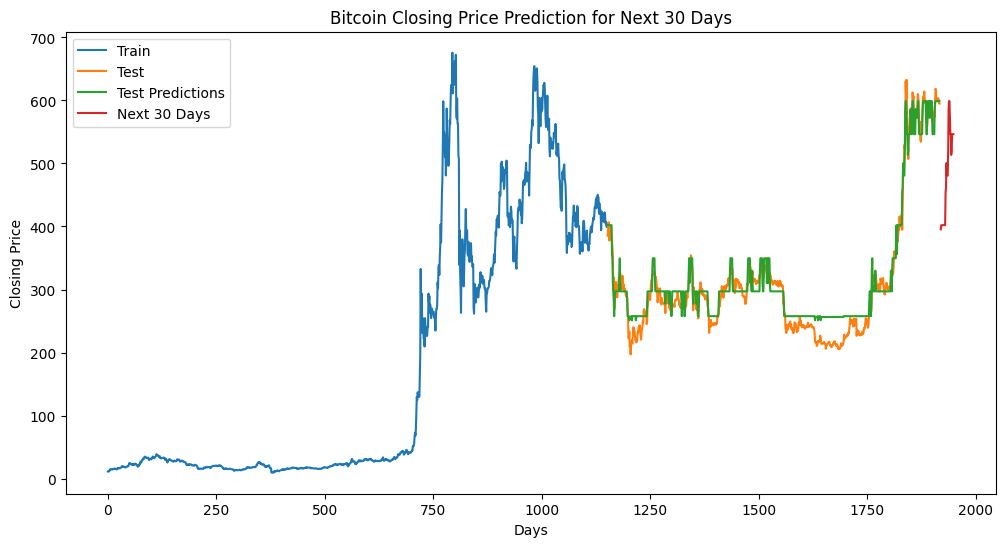

Predicted closing prices for the next 30 days:
[395.53224569 402.09300502 402.09300502 402.09300502 402.09300502
 402.09300502 402.09300502 402.09300502 402.09300502 402.09300502
 402.09300502 454.57907966 461.139839   500.50439498 480.82211699
 480.82211699 480.82211699 520.18667297 585.79426627 598.91578493
 598.91578493 572.67274761 546.42971029 546.42971029 513.62591364
 520.18667297 546.42971029 546.42971029 546.42971029 546.42971029]


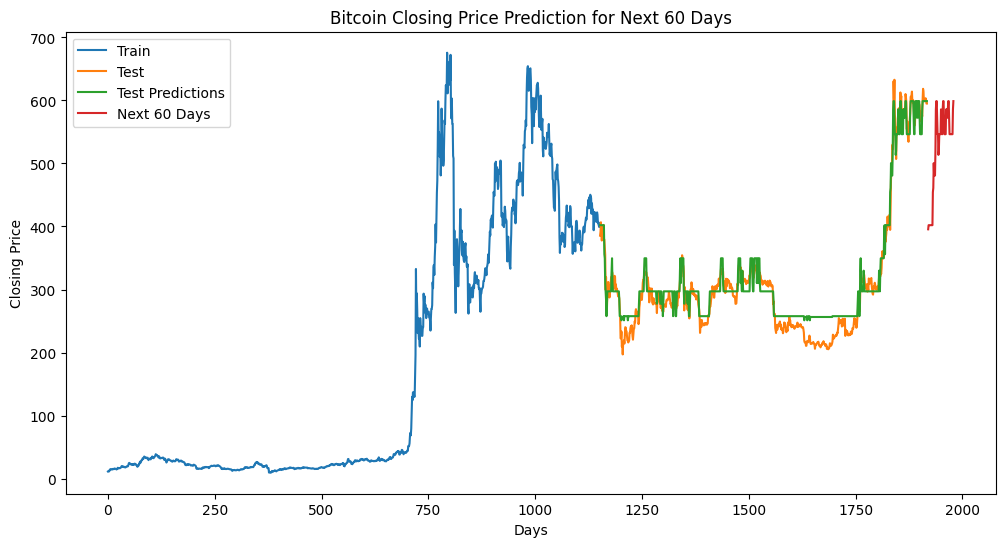

Predicted closing prices for the next 60 days:
[395.53224569 402.09300502 402.09300502 402.09300502 402.09300502
 402.09300502 402.09300502 402.09300502 402.09300502 402.09300502
 402.09300502 454.57907966 461.139839   500.50439498 480.82211699
 480.82211699 480.82211699 520.18667297 585.79426627 598.91578493
 598.91578493 572.67274761 546.42971029 546.42971029 513.62591364
 520.18667297 546.42971029 546.42971029 546.42971029 546.42971029
 585.79426627 572.67274761 546.42971029 546.42971029 585.79426627
 598.91578493 598.91578493 572.67274761 546.42971029 546.42971029
 546.42971029 546.42971029 585.79426627 572.67274761 585.79426627
 572.67274761 585.79426627 598.91578493 598.91578493 572.67274761
 546.42971029 546.42971029 546.42971029 546.42971029 546.42971029
 546.42971029 546.42971029 546.42971029 585.79426627 598.91578493]


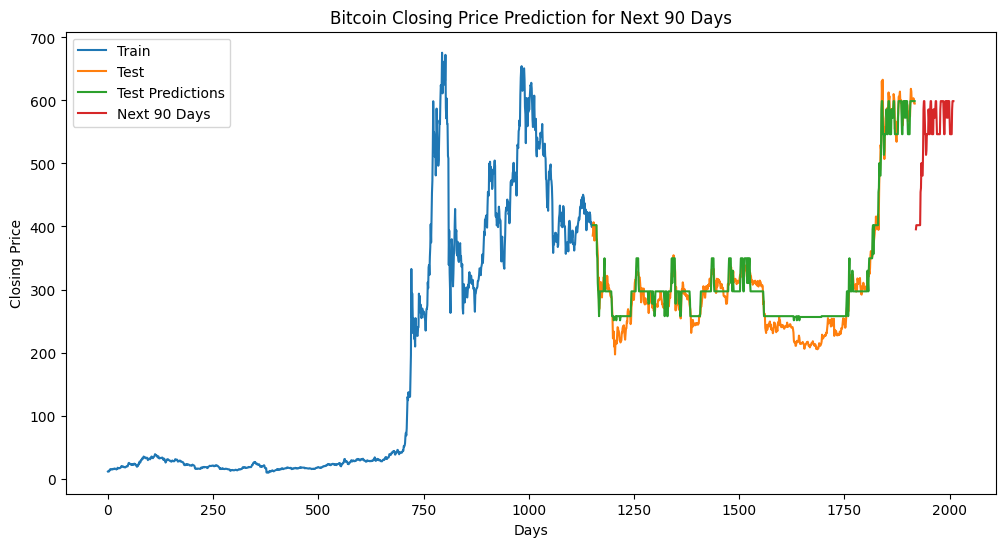

Predicted closing prices for the next 90 days:
[395.53224569 402.09300502 402.09300502 402.09300502 402.09300502
 402.09300502 402.09300502 402.09300502 402.09300502 402.09300502
 402.09300502 454.57907966 461.139839   500.50439498 480.82211699
 480.82211699 480.82211699 520.18667297 585.79426627 598.91578493
 598.91578493 572.67274761 546.42971029 546.42971029 513.62591364
 520.18667297 546.42971029 546.42971029 546.42971029 546.42971029
 585.79426627 572.67274761 546.42971029 546.42971029 585.79426627
 598.91578493 598.91578493 572.67274761 546.42971029 546.42971029
 546.42971029 546.42971029 585.79426627 572.67274761 585.79426627
 572.67274761 585.79426627 598.91578493 598.91578493 572.67274761
 546.42971029 546.42971029 546.42971029 546.42971029 546.42971029
 546.42971029 546.42971029 546.42971029 585.79426627 598.91578493
 598.91578493 598.91578493 598.91578493 598.91578493 598.91578493
 598.91578493 572.67274761 546.42971029 546.42971029 585.79426627
 598.91578493 598.91578493 59

In [73]:
# 10. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[-time_step:])
    lst_output = []

    for _ in range(days):
        x_input = np.array(temp_input[-time_step:])  # Lấy 100 dữ liệu lịch sử
        yhat = model.predict(x_input)[0]  # Dự đoán dữ liệu tiếp theo
        temp_input.append(yhat)
        lst_output.append(yhat)

    return np.array(lst_output)

last_100_days = df1[-100:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, 100, days)

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_data)), train_data, label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), y_pred_test, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'Bitcoin Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())